In [1]:
# Import Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
import os
%matplotlib inline

# Defining VPD Function
def vpdfun (T_Grid, RH_Grid): 
    '''
    Uses the inputs of Temperature (Celsius) and relative humidity (%RH) and outputs the VPD (kPa).
    Inputs must be in numpy 2D array T in Celsius and RH in %RH with same dimensions.
    Author: Nathan Hein
    Date: 03/03/2019    
    '''
    esat = .611 * (np.exp((T_Grid * 17.5) / (T_Grid + 241))) # Sat. Vapor Pressure
    eact = esat * (RH_Grid / 100)                            # Actual Vapor Pressure
    vpd = esat - eact                                        # Vapr Pressure Deficit
    vpd = np.round(vpd, 2) 
    return vpd



In [2]:
# Set variables for data directory, results directory, datafile, start date, end date, and creates a results directory for the file.  

datadirname = '/Users/nhein/Desktop/Coding/Project/Data/'
resultsdirname = '/Users/nhein/Desktop/Coding/Project/Results/'

if os.path.isdir(resultsdirname) == False:
    os.makedirs(resultsdirname)

datafile = 'Ch17-36C.csv'
start_date = ['2018-12-01']
end_date = ['2018-12-05']

filename = datafile.split('.')[0]

if os.path.isdir(resultsdirname + filename) == False:
    os.makedirs(resultsdirname + filename)

# Uses start date and end date to create simple dataframe for reference for trimming down main dataframe    

date_range_df = pd.DataFrame(start_date)
date_range_df.columns = ['Start_Date']
date_range_df.insert(1, 'End_Date', end_date)
date_range_df.Start_Date = pd.to_datetime(date_range_df.Start_Date)
date_range_df.Start_Date = date_range_df.Start_Date.dt.date
date_range_df.End_Date = pd.to_datetime(date_range_df.End_Date)
date_range_df.End_Date = date_range_df.End_Date.dt.date

# Import File and delete superfulous columns

df = pd.read_csv(datadirname + datafile, skiprows=1)
df.drop(df.columns[0], axis=1, inplace= True)
df.drop(df.columns[range(3, len(df.columns))], axis=1, inplace = True)
df.columns = ['Full_Date', 'Temp_C', 'RH']

# Change dates to datetime and create new columns with date data needed for calculations
df.Full_Date = pd.to_datetime(df.Full_Date)
df.insert(1,'Date', df.Full_Date.dt.date)
df.insert(2,'Time', df.Full_Date.dt.time)
df.insert(3, 'Hour', df.Full_Date.dt.hour)

# drop rows witn NaNs
df = df.dropna()

# Uses date dataframe to trim the top and bottome of the main dataframe
k = 0
start_date_index = []
end_date_index = []
len_date = len(df.Date)

for k in range(0, len_date):
    if df.Date[k] == date_range_df.Start_Date[0]:
        start_date_index.append(k) 
    if df.Date[k] == date_range_df.End_Date[0]:
        end_date_index.append(k)

df = df.drop(index = range(0, start_date_index[0]))
df = df.drop(index = range(end_date_index[-1] + 1, len_date))
df = df.reset_index(drop = True) 

# Defining Temp and RH variables
T_Grid = df.Temp_C
RH_Grid = df.RH

# Calling function and creating new column in dataframe with VPD.
VPD = vpdfun(T_Grid, RH_Grid)
df.insert(6,'VPD', VPD)

# Saves main dataframe to results directory
df.to_csv(resultsdirname + filename + '/' + filename + '-Data.csv')


In [3]:
# Defining function that averages the VPD values over a given hour of the day for the entire data set.
def monthlyvpd ():
    '''
    Takes the calculated VPD and averages all values that were measured during each hour of the day throughout the data period.
    Records the results in a new dataframe.
    Inputs: VPD as an integer from a dataframe created from a csv file and results are the same units as inputs (normally kPA).  
    Author: Nathan Hein
    Date: 03/11/19
    '''
    cols = ['Hour', 'VPD']
    rows = []
    xdf = pd.DataFrame(rows, columns=cols)
    vpdlist = []
    for x in range(0,24):
        vpd = df[df['Hour']==x]['VPD']
        vpdlist.append(vpd)
        avg = np.mean(vpdlist)
        xdf = xdf.append({'Hour': x, 'VPD': avg}, ignore_index=True)
        vpdlist = []
    return(xdf)

# Defining Function that average the temp values over a given hour of the day for the entire data set.
def monthlytemp ():
    '''
    Calculates the average temperature for each hour of the day over the entire data set.
    Inputs: Temperature as an integer in a dataframe created from a csv file.
    Outputs: Temperature as an integer and a new dataframe with average temeperature values and the hour.
    Author: Nathan Hein
    Date: 03/11/19
    '''
    cols = ['Hour', 'Temp']
    rows = []
    ydf = pd.DataFrame(rows, columns=cols)
    templist = []
    for x in range(0,24):
        temp = df[df['Hour']==x]['Temp_C']
        templist.append(temp)
        avg = np.mean(templist)
        ydf = ydf.append({'Hour': x, 'Temp': avg}, ignore_index=True)
        templist = []
    return(ydf)

# Defining function that averages the RH values over a given hour of the day for the entire data set.
def monthlyrh ():
    '''
    Calculates the average RH value for each hour of the day over the entire data set.
    Input: RH from a dataframe created from the imported CSV file
    Output: Hourly average RH in a new dataframe and the hour.
    Author: Nathan Hein
    Date: 03/11/19
    '''
    
    cols = ['Hour', 'RH']
    rows = []
    zdf = pd.DataFrame(rows, columns=cols)
    rhlist = []
    for x in range(0,24):
        rh = df[df['Hour']==x]['RH']
        rhlist.append(rh)
        avg = np.mean(rhlist)
        zdf = zdf.append({'Hour': x, 'RH': avg}, ignore_index=True)
        rhlist = []
    return(zdf)

# Call all functions to create dataframes for average VPD Temp and RH for each hour
MonthlyHourlyVPD = monthlyvpd()
MonthlyHourlyTemp = monthlytemp()
MonthlyHourlyRH = monthlyrh()

# Creates a list of the different Data types data frames and merges all the resuls data frames into one.
data_frames = [MonthlyHourlyTemp, MonthlyHourlyRH, MonthlyHourlyVPD]
MHA_Merged = pd.merge(pd.merge(MonthlyHourlyTemp,MonthlyHourlyRH,on='Hour'),MonthlyHourlyVPD,on='Hour')

# Saves the results to directory
MHA_Merged.to_csv(resultsdirname + filename + '/' + filename + '-MHA_Merged.csv')

C:\Users\nhein\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


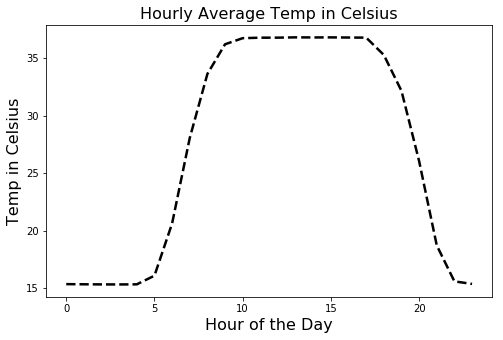

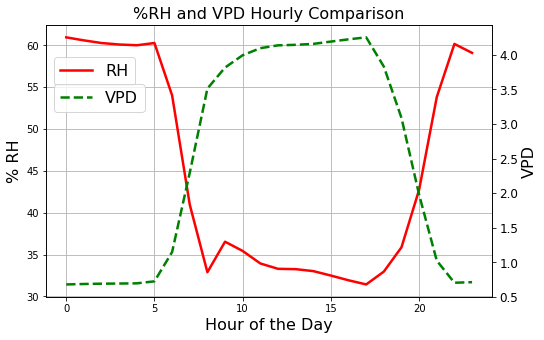

In [4]:
# Create plot with line graph of Hourly Average Temp in Celsius
plt.figure(figsize=(8,5))
plt.plot(MHA_Merged.Hour, MHA_Merged.Temp, color = 'k', linewidth = 2.5, linestyle = '--')
plt.title('Hourly Average Temp in Celsius', fontsize = 16)
plt.xlabel('Hour of the Day', fontsize = 16)
plt.ylabel('Temp in Celsius', fontsize = 16)
plt.rcParams['axes.grid'] = True
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['axes.facecolor'] = 'w'

plt.savefig(resultsdirname + filename + '/' + filename + '-HourlyAVGTemp.jpg', bbox_inches = 'tight')


# Creates a plot with both the hourly average %RH and the average VPD.

plt.figure(figsize=(8,5))
plt.title('%RH and VPD Hourly Comparison', fontsize = 16)
plt.rcParams['axes.grid'] = False
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['axes.facecolor'] = 'w'

ax1 = plt.subplot()
ax1.plot(MHA_Merged.Hour, MHA_Merged.RH, color = 'r', linewidth = 2.5)
plt.legend(loc = 'lower left', bbox_to_anchor = (0,.75), fontsize = 16)

ax2 = ax1.twinx()
ax2.plot(MHA_Merged.Hour, MHA_Merged.VPD, color = 'g', linewidth = 2.5, linestyle = '--')
plt.legend(loc = 'lower left', bbox_to_anchor = (0,.65), fontsize = 16)

ax1.set_xlabel('Hour of the Day', fontsize = 16)
ax1.set_ylabel('% RH', fontsize = 16)
ax2.set_ylabel('VPD', fontsize = 16)

plt.savefig(resultsdirname + filename + '/' + filename + '-RHandVPDCompFig.jpg', bbox_inches = 'tight')

In [6]:
# Creates a dataframe with hourly temperature average for each day 
days = []
hours = [range(0,24)]
TempHourlyAvgdf = pd.DataFrame(hours)
TempHourlyAvgdf = TempHourlyAvgdf.drop(TempHourlyAvgdf.index[0])
TempHourlyAvgdf.insert(0,'Date','')

deltadays = date_range_df.End_Date[0] - date_range_df.Start_Date[0]

for i in range(0, deltadays.days + 1):
    days.append(date_range_df.Start_Date[0] + timedelta(i))

TempHourlyAvgdf.Date = days

HAVGTemp = []

for j in range(0,len(days)):
    for i in range(0,24):
        org = df[(df.Hour == i) & (df.Date == days[j])]
        HAVGTemp.append(org.Temp_C)
        x = round(np.mean(HAVGTemp), 3)
        TempHourlyAvgdf[i][j] = x
        HAVGTemp = []
        
TempHourlyAvgdf.to_csv(resultsdirname + filename + '/' + filename + '-DHATemp.csv',)

# Creates a dataframe with hourly %RH average for each day 

RHHourlyAvgdf = pd.DataFrame(hours)
RHHourlyAvgdf = RHHourlyAvgdf.drop(RHHourlyAvgdf.index[0])
RHHourlyAvgdf.insert(0,'Date','')
RHHourlyAvgdf.Date = days

HAVGRH = []

for j in range(0,len(days)):
    for i in range(0,24):
        org = df[(df.Hour == i) & (df.Date == days[j])]
        HAVGRH.append(org.RH)
        x = round(np.mean(HAVGRH), 3)
        RHHourlyAvgdf[i][j] = x
        HAVGRH = []
        
RHHourlyAvgdf.to_csv(resultsdirname + filename + '/' + filename + '-DHARH.csv')

# Creates a dataframe with hourly VPD average for each day 

VPDHourlyAvgdf = pd.DataFrame(hours)
VPDHourlyAvgdf = VPDHourlyAvgdf.drop(VPDHourlyAvgdf.index[0])
VPDHourlyAvgdf.insert(0,'Date','')
VPDHourlyAvgdf.Date = days

HAVGVPD = []

for j in range(0,len(days)):
    for i in range(0,24):
        org = df[(df.Hour == i) & (df.Date == days[j])]
        HAVGVPD.append(org.VPD)
        x = round(np.mean(HAVGVPD), 3)
        VPDHourlyAvgdf[i][j] = x
        HAVGVPD = []
        
VPDHourlyAvgdf.to_csv(resultsdirname + filename + '/' + filename + '-DHAVPD.csv')

C:\Users\nhein\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\nhein\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\nhein\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
print(TempHourlyAvgdf)
print(RHHourlyAvgdf)
print(VPDHourlyAvgdf)

         Date       0       1       2       3       4       5       6       7  \
0  2018-12-01  15.333  15.375  15.417  15.405  15.399  16.114  20.670  28.055   
1  2018-12-02  15.339  15.309  15.279  15.297  15.285  16.102  20.634  28.068   
2  2018-12-03  15.327  15.309  15.297  15.285  15.327  16.078  20.623  28.067   
3  2018-12-04  15.363  15.327  15.333  15.327  15.375  16.073  20.611  28.055   
4  2018-12-05  15.381  15.351  15.303  15.291  15.267  16.049  20.593  28.030   

        8   ...        14      15      16      17      18      19      20  \
0  33.593   ...    36.833  36.867  36.772  36.846  35.306  32.219  26.106   
1  33.652   ...    36.847  36.826  36.854  36.847  35.293  32.181  26.057   
2  33.658   ...    36.847  36.860  36.799  36.806  35.326  32.174  26.033   
3  33.612   ...    36.710  36.690  36.738  36.622  35.213  32.065  25.978   
4  33.607   ...    36.751  36.772  36.792  36.786  35.233  32.110  26.027   

       21      22      23  
0  18.770  15.602  15.